In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from lime import lime_image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from skimage.transform import resize
import gc

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, 50177)  # Match saved state_dict
state_dict_path = "/kaggle/input/glasses-dataset/efficientnet_glasses_recognition_model.pth"
state_dict = torch.load(state_dict_path, map_location=device)
model.load_state_dict(state_dict)
model.classifier[1] = torch.nn.Linear(num_features, 1)  # Binary classification
model.to(device).eval()
model.half()  # Use mixed precision
print("Model loaded successfully and updated for binary classification.")

# Image preprocessing
def preprocess_image(img_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device).half()  # Convert to half-precision
    return img_tensor, np.array(img)

# Resize explanation maps
def resize_to_original_size(explanation, original_size):
    return resize(explanation, original_size, mode='reflect', anti_aliasing=True)

# Save heatmaps
def save_heatmap(original_img, heatmap, output_path):
    heatmap_resized = resize_to_original_size(heatmap, original_img.shape[:2])
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

# Grad-CAM implementation
def make_gradcam_heatmap(model, img_tensor, target_layer):
    gradients, activations = [], []

    def hook_grad(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    def hook_activation(module, input, output):
        activations.append(output.detach())

    # Attach hooks
    handle_grad = target_layer.register_full_backward_hook(hook_grad)
    handle_activation = target_layer.register_forward_hook(hook_activation)

    # Forward pass
    output = model(img_tensor)
    target_class = output.argmax(dim=1).item()
    loss = output[0, target_class]

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Compute Grad-CAM
    gradients_np = gradients[0].cpu().numpy()  # Move to CPU before conversion
    activations_np = activations[0].cpu().numpy()  # Move to CPU before conversion
    weights = np.mean(gradients_np, axis=(2, 3))
    heatmap = np.sum(weights[:, :, None, None] * activations_np, axis=1).squeeze()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1  # Normalize

    # Remove hooks
    handle_grad.remove()
    handle_activation.remove()

    return heatmap

# Integrated Gradients
def compute_integrated_gradients(model, img_tensor, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(img_tensor).to(device).half()  # Match precision

    gradients = []
    for alpha in np.linspace(0, 1, steps + 1):
        scaled_input = baseline + alpha * (img_tensor - baseline)
        scaled_input.requires_grad = True
        output = model(scaled_input)
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward()
        gradients.append(scaled_input.grad.cpu().numpy())  # Move to CPU before conversion

    avg_gradients = np.mean(gradients, axis=0)
    integrated_gradients = (img_tensor.cpu().numpy() - baseline.cpu().numpy()) * avg_gradients
    integrated_gradients = np.abs(integrated_gradients).sum(axis=1).squeeze()
    return integrated_gradients / np.max(integrated_gradients) if np.max(integrated_gradients) > 0 else integrated_gradients

# LIME explanation function
def explain_with_lime(model, img_tensor, original_img):
    def predict_function(imgs):
        imgs_tensor = torch.stack([transforms.ToTensor()(Image.fromarray((img * 255).astype('uint8'))) for img in imgs]).to(device).half()
        outputs = model(imgs_tensor)
        return outputs.softmax(dim=1).detach().cpu().numpy()  # Move to CPU before conversion

    img_np = original_img / 255.0
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_np.astype('float32'), predict_function, top_labels=1, hide_color=0, num_samples=1000)
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    return mask.astype('float32')

# Metrics calculation including faithfulness
def compute_metrics(explanation, predictions):
    explanation_flat = explanation.flatten()
    predictions_flat = predictions.flatten()

    # Ensure same size for both arrays
    min_size = min(len(explanation_flat), len(predictions_flat))
    explanation_flat = explanation_flat[:min_size]
    predictions_flat = predictions_flat[:min_size]

    # Faithfulness (correlation)
    faithfulness = np.corrcoef(explanation_flat, predictions_flat)[0, 1] if len(explanation_flat) > 0 else np.nan
    sparsity = 1 - (np.sum(explanation > 0) / explanation.size)
    complexity = np.sum(explanation > 0.5)

    return {"Faithfulness": faithfulness, "Sparsity": sparsity, "Complexity": complexity}

# Process folder
def process_folder(model, input_folder, output_folder, target_layer, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        try:
            img_tensor, original_img = preprocess_image(file_path, target_size)
            target_class = model(img_tensor).argmax(dim=1).item()

            # Grad-CAM
            gradcam = make_gradcam_heatmap(model, img_tensor, target_layer)
            gradcam = resize_to_original_size(gradcam, original_img.shape[:2])
            gradcam_metrics = compute_metrics(gradcam, img_tensor.cpu().squeeze().numpy())

            # Integrated Gradients
            integrated_gradients = compute_integrated_gradients(model, img_tensor, target_class)
            integrated_gradients = resize_to_original_size(integrated_gradients, original_img.shape[:2])
            integrated_metrics = compute_metrics(integrated_gradients, img_tensor.cpu().squeeze().numpy())

            # LIME
            lime_mask = explain_with_lime(model, img_tensor, original_img)
            lime_mask = resize_to_original_size(lime_mask, original_img.shape[:2])
            lime_metrics = compute_metrics(lime_mask, img_tensor.cpu().squeeze().numpy())

            # Save heatmaps
            save_heatmap(original_img, gradcam, os.path.join(output_folder, f"{file_name}_gradcam.png"))
            save_heatmap(original_img, integrated_gradients, os.path.join(output_folder, f"{file_name}_integrated.png"))
            save_heatmap(original_img, lime_mask, os.path.join(output_folder, f"{file_name}_lime.png"))

            results.append({
                "File": file_name,
                "Grad-CAM": gradcam_metrics,
                "Integrated Gradients": integrated_metrics,
                "LIME": lime_metrics
            })

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

        # Clear memory after processing each image
        gc.collect()

    return results

# Specify folders
input_folder = "/kaggle/input/glasses-dataset/glasses/glasses/Test"
output_folder = "/kaggle/working/glasses_xai_outputs"
target_layer = model.features[-1]

# Process dataset
results = process_folder(model, input_folder, output_folder, target_layer)

# Save results
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(output_folder, "metrics_results.csv")
results_df.to_csv(results_csv_path, index=False)

print(f"Metrics saved to {results_csv_path}")


In [36]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import ast
import numpy as np


def visualize_heatmaps_with_metrics(image_path, gradcam_path, integrated_path, lime_path, metrics, output_path):
    """
    Generate a 2x2 plot with the original image, Grad-CAM, Integrated Gradients, and LIME heatmaps
    along with their corresponding metrics and save the visualization.
    """
    def format_metric(value):
        """
        Safely format the metric for display. If the value is numeric, format it to 4 decimal places.
        Otherwise, return it as is.
        """
        if isinstance(value, (float, int)) and not np.isnan(value):
            return f"{value:.4f}"
        return str(value)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Load images
    original_img = mpimg.imread(image_path)
    gradcam_img = mpimg.imread(gradcam_path)
    integrated_img = mpimg.imread(integrated_path)
    lime_img = mpimg.imread(lime_path)

    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Grad-CAM
    axes[0, 1].imshow(gradcam_img)
    gradcam_metrics = metrics.get("Grad-CAM", {})
    axes[0, 1].set_title(f"Grad-CAM\nFaithfulness: {format_metric(gradcam_metrics.get('Faithfulness', 'N/A'))}\n"
                         f"Sparsity: {format_metric(gradcam_metrics.get('Sparsity', 'N/A'))}\n"
                         f"Complexity: {format_metric(gradcam_metrics.get('Complexity', 'N/A'))}")
    axes[0, 1].axis('off')

    # Integrated Gradients
    axes[1, 0].imshow(integrated_img)
    integrated_metrics = metrics.get("Integrated Gradients", {})
    axes[1, 0].set_title(f"Integrated Gradients\nFaithfulness: {format_metric(integrated_metrics.get('Faithfulness', 'N/A'))}\n"
                         f"Sparsity: {format_metric(integrated_metrics.get('Sparsity', 'N/A'))}\n"
                         f"Complexity: {format_metric(integrated_metrics.get('Complexity', 'N/A'))}")
    axes[1, 0].axis('off')

    # LIME
    axes[1, 1].imshow(lime_img)
    lime_metrics = metrics.get("LIME", {})
    axes[1, 1].set_title(f"LIME\nFaithfulness: {format_metric(lime_metrics.get('Faithfulness', 'N/A'))}\n"
                         f"Sparsity: {format_metric(lime_metrics.get('Sparsity', 'N/A'))}\n"
                         f"Complexity: {format_metric(lime_metrics.get('Complexity', 'N/A'))}")
    axes[1, 1].axis('off')

    # Save visualization
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close(fig)


def safe_eval(string):
    """
    Safely evaluate a stringified dictionary and handle NaN values gracefully.
    """
    try:
        # Use ast.literal_eval for safe evaluation
        data = ast.literal_eval(string)
        # Replace NaN with np.nan for compatibility
        return {key: (np.nan if value == 'nan' else value) for key, value in data.items()}
    except Exception as e:
        print(f"Error evaluating string: {string}\n{e}")
        return {}


def generate_visualizations(input_folder, heatmap_folder, results_csv_path, output_visualizations_folder):
    """
    Generate heatmap visualizations with metrics for all images in the input folder.
    """
    if not os.path.exists(output_visualizations_folder):
        os.makedirs(output_visualizations_folder)

    # Load metrics from the CSV file
    results_df = pd.read_csv(results_csv_path)

    # Ensure the "File" column contains valid strings
    if "File" in results_df.columns:
        results_df["File"] = results_df["File"].astype(str)
    else:
        print("Error: 'File' column is missing from the input CSV.")
        return

    for _, row in results_df.iterrows():
        file_name = row["File"]

        # Skip invalid or missing filenames
        if file_name == "nan" or not file_name or not isinstance(file_name, str):
            print(f"Skipping invalid file entry: {file_name}")
            continue

        # Construct image file path and check existence
        image_path = os.path.join(input_folder, file_name)
        if not os.path.exists(image_path):
            print(f"File not found, skipping: {image_path}")
            continue

        gradcam_metrics = safe_eval(row["Grad-CAM"])
        integrated_metrics = safe_eval(row["Integrated Gradients"])
        lime_metrics = safe_eval(row["LIME"])

        # Paths to heatmaps
        gradcam_path = os.path.join(heatmap_folder, f"{file_name}_gradcam.png")
        integrated_path = os.path.join(heatmap_folder, f"{file_name}_integrated.png")
        lime_path = os.path.join(heatmap_folder, f"{file_name}_lime.png")
        output_path = os.path.join(output_visualizations_folder, f"{file_name}_visualization.png")

        # Validate heatmap paths
        if not os.path.exists(gradcam_path) or not os.path.exists(integrated_path) or not os.path.exists(lime_path):
            print(f"Missing heatmap(s) for file: {file_name}, skipping.")
            continue

        # Collect metrics for the image
        metrics = {
            "Grad-CAM": gradcam_metrics,
            "Integrated Gradients": integrated_metrics,
            "LIME": lime_metrics
        }

        # Generate visualization
        visualize_heatmaps_with_metrics(image_path, gradcam_path, integrated_path, lime_path, metrics, output_path)
        print(f"Saved visualization for {file_name} at {output_path}")


# Input and output paths
input_folder = "Test"  # Folder containing original images
heatmap_folder = "glasses_xai_outputs"  # Folder containing Grad-CAM, Integrated Gradients, and LIME heatmaps
results_csv_path = os.path.join(heatmap_folder, "metrics_results.csv")  # Path to the metrics CSV file
output_visualizations_folder = "visualizations"  # Folder to save visualizations

# Generate visualizations
generate_visualizations(input_folder, heatmap_folder, results_csv_path, output_visualizations_folder)


Saved visualization for 04484.jpg at visualizations/04484.jpg_visualization.png
Saved visualization for 01688.jpg at visualizations/01688.jpg_visualization.png
Saved visualization for 10770.jpg at visualizations/10770.jpg_visualization.png
Saved visualization for 01537.jpg at visualizations/01537.jpg_visualization.png
Saved visualization for 07501.jpg at visualizations/07501.jpg_visualization.png
Saved visualization for 02922.jpg at visualizations/02922.jpg_visualization.png


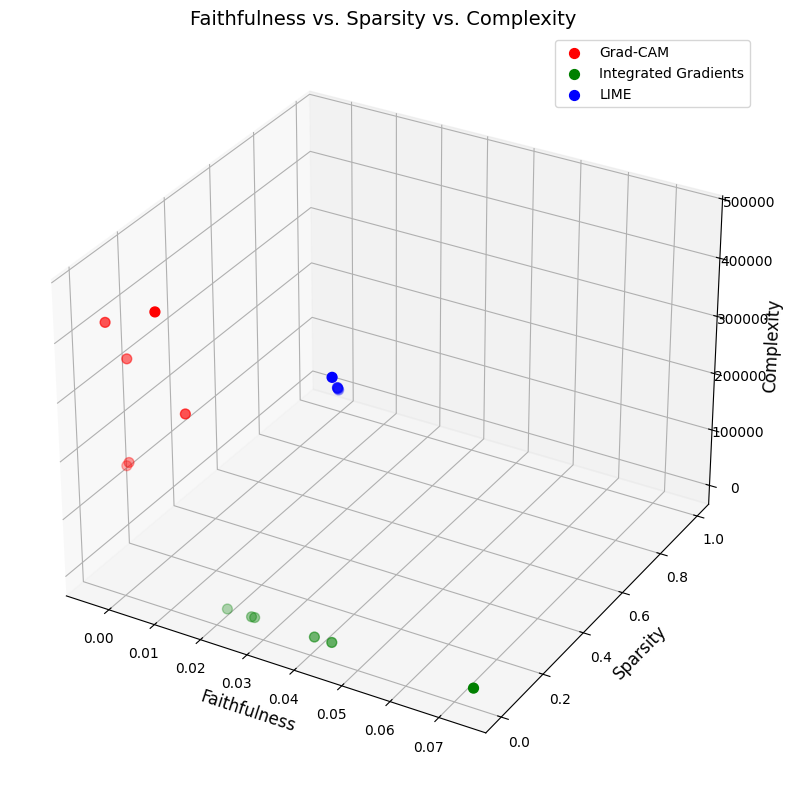

3D plot saved at faithfulness_sparsity_complexity_plot.png


In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_faithfulness_sparsity_complexity(results_csv_path, output_path):
    """
    Generate a 3D scatter plot for Faithfulness, Sparsity, and Complexity.
    Args:
        results_csv_path: Path to the metrics CSV file.
        output_path: Path to save the 3D plot as an image.
    """
    # Load metrics from the CSV file
    results_df = pd.read_csv(results_csv_path)

    # Initialize data containers for each method
    methods = ["Grad-CAM", "Integrated Gradients", "LIME"]
    data = {method: {"Faithfulness": [], "Sparsity": [], "Complexity": []} for method in methods}

    # Extract metrics for each method
    for _, row in results_df.iterrows():
        for method in methods:
            metrics = eval(row[method])  # Convert string representation of dictionary to actual dictionary
            data[method]["Faithfulness"].append(metrics.get("Faithfulness", 0))
            data[method]["Sparsity"].append(metrics.get("Sparsity", 0))
            data[method]["Complexity"].append(metrics.get("Complexity", 0))

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each method
    colors = ['r', 'g', 'b']  # Colors for Grad-CAM, Integrated Gradients, LIME
    for method, color in zip(methods, colors):
        ax.scatter(
            data[method]["Faithfulness"],
            data[method]["Sparsity"],
            data[method]["Complexity"],
            label=method,
            color=color,
            s=50  # Marker size
        )

    # Set axis labels
    ax.set_xlabel("Faithfulness", fontsize=12)
    ax.set_ylabel("Sparsity", fontsize=12)
    ax.set_zlabel("Complexity", fontsize=12)

    # Set plot title
    ax.set_title("Faithfulness vs. Sparsity vs. Complexity", fontsize=14)

    # Add legend
    ax.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"3D plot saved at {output_path}")


# Paths
results_csv_path = "glasses_xai_outputs/metrics_results.csv"  # Path to metrics CSV file
output_plot_path = "faithfulness_sparsity_complexity_plot.png"  # Path to save the plot

# Generate the 3D plot
plot_faithfulness_sparsity_complexity(results_csv_path, output_plot_path)
